<a href="https://colab.research.google.com/github/Kirill-149/Programming_Paradigms/blob/main/Lab_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
format ELF64
public _start

SYS_WRITE       = 1
SYS_CLOSE       = 3
SYS_SOCKET      = 41
SYS_ACCEPT      = 43
SYS_BIND        = 49
SYS_LISTEN      = 50
SYS_EXIT        = 60

AF_INET         = 2
SOCK_STREAM     = 1
INADDR_ANY      = 0

section '.data' writeable
    notify_ready    db '[Server started on port 5555]', 10, 0
    notify_player   db '[New connection]', 10, 0

    buffer_in       rb 256
    buffer_out      rb 1024

    host_address:
        dw AF_INET
        db 0x15, 0xB3    ; Порт 5555 (0xB315 в сетевом порядке байт)
        dd INADDR_ANY
        dq 0

    main_socket     dq 0
    game_socket     dq 0

    challenger_pts  dq 0
    host_pts        dq 0

    challenger_cards rb 20
    challenger_count dq 0

    host_cards      rb 20
    host_count      dq 0

    deck_pointer    dq 0
    rand_seed       dq 987654321

    face_symbols    db '2','3','4','5','6','7','8','9','X','V','Q','K','A'

    card_strength   db 2,2,2,2, 3,3,3,3, 4,4,4,4, 5,5,5,5, 6,6,6,6, 7,7,7,7, 8,8,8,8, 9,9,9,9
                    db 10,10,10,10
                    db 10,10,10,10
                    db 10,10,10,10
                    db 10,10,10,10
                    db 10,10,10,10

    shuffled_deck   db 52 dup(0)

section '.text' executable
_start:
    mov rcx, 52
    xor rax, rax
.init_deck:
    mov [shuffled_deck + rax], al
    inc rax
    loop .init_deck

    mov rax, SYS_SOCKET
    mov rdi, AF_INET
    mov rsi, SOCK_STREAM
    mov rdx, 0
    syscall
    mov [main_socket], rax

    mov rax, SYS_BIND
    mov rdi, [main_socket]
    mov rsi, host_address
    mov rdx, 16
    syscall

    mov rax, SYS_LISTEN
    mov rdi, [main_socket]
    mov rsi, 1
    syscall

    mov rsi, notify_ready
    call output_message

accept_cycle:
    mov rax, SYS_ACCEPT
    mov rdi, [main_socket]
    mov rsi, 0
    mov rdx, 0
    syscall
    mov [game_socket], rax

    mov rsi, notify_player
    call output_message

session_start:
    mov qword [challenger_pts], 0
    mov qword [host_pts], 0
    mov qword [deck_pointer], 0

    mov qword [challenger_count], 0
    mov qword [host_count], 0

    call shuffle_cards

    mov rdi, 0
    call draw_card
    mov rdi, 0
    call draw_card

    mov rdi, 1
    call draw_card
    mov rdi, 1
    call draw_card

    cmp qword [challenger_pts], 20
    je verify_host_blackjack

    call display_hidden_state
    jmp game_cycle

game_cycle:
    mov rax, 0
    mov rdi, [game_socket]
    mov rsi, buffer_in
    mov rdx, 255
    syscall

    cmp rax, 0
    jle terminate_session

    mov al, byte [buffer_in]

    cmp al, '1'
    je request_card

    cmp al, '2'
    je freeze_turn

    jmp terminate_session

request_card:
    mov rdi, 0
    call draw_card
    cmp qword [challenger_pts], 21
    jg challenger_busted
    call display_hidden_state
    jmp game_cycle

freeze_turn:
host_move:
    cmp qword [host_pts], 17
    jge host_finished
    mov rdi, 1
    call draw_card
    jmp host_move

host_finished:
    mov rax, [host_pts]
    cmp rax, 21
    jg challenger_victory
    mov rbx, [challenger_pts]
    cmp rbx, rax
    jg challenger_victory
    jl challenger_defeat
    je match_draw

challenger_busted:
    mov rdi, buffer_out
    call message_busted
    jmp finalize_round

challenger_victory:
    mov rdi, buffer_out
    call message_victory
    jmp finalize_round

challenger_defeat:
    mov rdi, buffer_out
    call message_defeat
    jmp finalize_round

match_draw:
    mov rdi, buffer_out
    call message_draw
    jmp finalize_round

finalize_round:
    mov rsi, buffer_out
    call transmit_output
    jmp terminate_session

terminate_session:
    mov rax, SYS_CLOSE
    mov rdi, [game_socket]
    syscall
    jmp accept_cycle

verify_host_blackjack:
    cmp qword [host_pts], 20
    je match_draw
    jmp challenger_victory

draw_card:
    push rbx
    push rcx
    push rdx

    mov rbx, [deck_pointer]
    movzx rax, byte [shuffled_deck + rbx]
    inc [deck_pointer]

    push rax
    push rdx
    xor rdx, rdx
    mov rbx, 4
    div rbx
    mov bl, [face_symbols + rax]
    pop rdx

    cmp rdi, 0
    je .store_challenger
    jmp .store_host

.store_challenger:
    mov rdx, [challenger_count]
    mov [challenger_cards + rdx], bl
    inc [challenger_count]
    jmp .store_complete
.store_host:
    mov rdx, [host_count]
    mov [host_cards + rdx], bl
    inc [host_count]
.store_complete:
    pop rax

    movzx rcx, byte [card_strength + rax]

    cmp rdi, 0
    je .update_challenger
    jmp .update_host
.update_challenger:
    add [challenger_pts], rcx
    jmp .complete
.update_host:
    add [host_pts], rcx
.complete:
    pop rdx
    pop rcx
    pop rbx
    ret

shuffle_cards:
    mov rcx, 51
.shuffle_loop:
    push rcx
    call generate_random
    xor rdx, rdx
    mov rbx, 52
    div rbx
    pop rcx
    mov al, [shuffled_deck + rcx]
    mov ah, [shuffled_deck + rdx]
    mov [shuffled_deck + rcx], ah
    mov [shuffled_deck + rdx], al
    loop .shuffle_loop
    ret

generate_random:
    push rbx
    push rcx
    push rdx
    mov rax, [rand_seed]
    mov rbx, 6364136223846793005
    mul rbx
    mov rcx, 1442695040888963407
    add rax, rcx
    mov [rand_seed], rax
    pop rdx
    pop rcx
    pop rbx
    ret

show_card_sequence:
    push rbx
    push rcx
    push rsi

    xor rbx, rbx
.sequence_loop:
    cmp rbx, rcx
    jge .sequence_end

    mov al, [rsi + rbx]
    mov [rdi], al
    inc rdi
    mov byte [rdi], ' '
    inc rdi

    inc rbx
    jmp .sequence_loop
.sequence_end:
    pop rsi
    pop rcx
    pop rbx
    ret

display_hidden_state:
    mov rdi, buffer_out

    mov dword [rdi], 'Host'
    mov dword [rdi+4], ':   '
    add rdi, 8

    mov al, [host_cards]
    mov [rdi], al
    inc rdi
    mov dword [rdi], ' [H]'
    add rdi, 4

    mov byte [rdi], 10
    inc rdi

    mov dword [rdi], 'Play'
    mov dword [rdi+4], 'er: '
    add rdi, 8
    mov rax, [challenger_pts]
    call convert_number
    mov byte [rdi], ' '
    inc rdi

    mov rsi, challenger_cards
    mov rcx, [challenger_count]
    call show_card_sequence

    mov byte [rdi], 10
    inc rdi

    mov dword [rdi], '1-TA'
    mov dword [rdi+4], 'KE 2'
    mov dword [rdi+8], '-HOL'
    mov byte [rdi+12], 'D'
    add rdi, 13

    mov byte [rdi], 10
    inc rdi

    mov byte [rdi], 0

    mov rsi, buffer_out
    call transmit_output
    ret

append_final_details:
    mov byte [rdi], 10
    inc rdi

    mov dword [rdi], 'Play'
    mov dword [rdi+4], 'er: '
    add rdi, 8
    mov rax, [challenger_pts]
    call convert_number
    mov byte [rdi], ' '
    inc rdi
    mov rsi, challenger_cards
    mov rcx, [challenger_count]
    call show_card_sequence

    mov byte [rdi], 10
    inc rdi

    mov dword [rdi], 'Host'
    mov dword [rdi+4], ':   '
    add rdi, 8
    mov rax, [host_pts]
    call convert_number
    mov byte [rdi], ' '
    inc rdi
    mov rsi, host_cards
    mov rcx, [host_count]
    call show_card_sequence

    mov byte [rdi], 10
    inc rdi

    mov byte [rdi], 0
    ret

message_busted:
    mov dword [rdi], 'OVER'
    mov byte [rdi+4], '!'
    add rdi, 5
    jmp append_final_details
message_victory:
    mov dword [rdi], 'WINN'
    mov dword [rdi+4], 'ER!'
    add rdi, 8
    jmp append_final_details
message_defeat:
    mov dword [rdi], 'LOST'
    mov byte [rdi+4], '!'
    add rdi, 5
    jmp append_final_details
message_draw:
    mov dword [rdi], 'DRAW'
    add rdi, 4
    jmp append_final_details

convert_number:
    push rbx
    push rdx
    mov rbx, 10
    xor rdx, rdx
    div rbx
    add al, '0'
    add dl, '0'
    mov [rdi], al
    inc rdi
    mov [rdi], dl
    inc rdi
    pop rdx
    pop rbx
    ret

transmit_output:
    push rdi
    push rax
    push rdx
    push rcx
    mov rdi, rsi
    call measure_text
    mov rdx, rax
    mov rax, SYS_WRITE
    mov rdi, [game_socket]
    syscall
    pop rcx
    pop rdx
    pop rax
    pop rdi
    ret

output_message:
    push rdi
    push rax
    push rdx
    push rcx
    mov rdi, rsi
    call measure_text
    mov rdx, rax
    mov rax, SYS_WRITE
    mov rdi, 1
    syscall
    pop rcx
    pop rdx
    pop rax
    pop rdi
    ret

measure_text:
    xor rax, rax
.scan_loop:
    cmp byte [rdi + rax], 0
    je .scan_done
    inc rax
    jmp .scan_loop
.scan_done:
    ret


In [ ]:
format ELF64
public _start

SYS_READ        = 0
SYS_WRITE       = 1
SYS_CLOSE       = 3
SYS_SOCKET      = 41
SYS_CONNECT     = 42
SYS_EXIT        = 60
AF_INET         = 2
SOCK_STREAM     = 1

section '.data' writeable
    notify_connect  db 'Initiating duel...', 10, 0
    error_socket    db 'Socket creation failed!', 10, 0
    error_connect   db 'Connection failed! Make sure server is running.', 10, 0

    target_address:
        dw AF_INET
        db 0x15, 0xB3      ; Порт 5555 (0xB315 в сетевом порядке байт)
        db 127,0,0,1       ; IP-адрес localhost
        dq 0

    comm_socket     dq 0
    server_reply    rb 512
    player_action   db 0

section '.text' executable
_start:
    mov rsi, notify_connect
    call show_text

    ; Создаем сокет
    mov rax, SYS_SOCKET
    mov rdi, AF_INET
    mov rsi, SOCK_STREAM
    mov rdx, 0
    syscall
    cmp rax, 0
    jl socket_error
    mov [comm_socket], rax

    ; Подключаемся к серверу
    mov rax, SYS_CONNECT
    mov rdi, [comm_socket]
    mov rsi, target_address
    mov rdx, 16
    syscall
    cmp rax, 0
    jl connect_error
    jmp match_loop

socket_error:
    mov rsi, error_socket
    call show_text
    jmp exit_program

connect_error:
    mov rsi, error_connect
    call show_text
    mov rax, SYS_CLOSE
    mov rdi, [comm_socket]
    syscall
    jmp exit_program

match_loop:
    ; Читаем ответ от сервера
    mov byte [server_reply], 0
    mov rax, SYS_READ
    mov rdi, [comm_socket]
    mov rsi, server_reply
    mov rdx, 511
    syscall

    cmp rax, 0
    jle disconnect

    ; Выводим ответ сервера
    mov rdx, rax
    mov rax, SYS_WRITE
    mov rdi, 1
    syscall

    ; Проверяем, не закончилась ли игра
    mov rsi, server_reply
    call check_game_over
    cmp rax, 1
    je disconnect

    ; Читаем выбор игрока
    mov rax, SYS_READ
    mov rdi, 0
    mov rsi, player_action
    mov rdx, 2
    syscall

    ; Отправляем выбор серверу
    mov rax, SYS_WRITE
    mov rdi, [comm_socket]
    mov rsi, player_action
    mov rdx, 1
    syscall

    jmp match_loop

check_game_over:
    ; Проверяем, содержит ли сообщение слова конца игры
    mov rcx, 0
.check_loop:
    mov al, [rsi + rcx]
    cmp al, 0
    je .not_over

    ; Проверяем на "OVER", "WINNER", "LOST", "DRAW"
    cmp al, 'O'
    je .check_over
    cmp al, 'W'
    je .check_winner
    cmp al, 'L'
    je .check_lost
    cmp al, 'D'
    je .check_draw
    jmp .continue

.check_over:
    cmp byte [rsi + rcx + 1], 'V'
    je .is_over
    jmp .continue
.check_winner:
    cmp byte [rsi + rcx + 1], 'I'
    je .is_over
    jmp .continue
.check_lost:
    cmp byte [rsi + rcx + 1], 'O'
    je .is_over
    jmp .continue
.check_draw:
    cmp byte [rsi + rcx + 1], 'R'
    je .is_over
    jmp .continue

.continue:
    inc rcx
    jmp .check_loop

.is_over:
    mov rax, 1
    ret
.not_over:
    mov rax, 0
    ret

disconnect:
    mov rax, SYS_CLOSE
    mov rdi, [comm_socket]
    syscall

exit_program:
    mov rax, SYS_EXIT
    xor rdi, rdi
    syscall

show_text:
    push rdi
    push rax
    push rdx
    push rcx
    mov rdi, rsi
    call text_length
    mov rdx, rax
    mov rax, SYS_WRITE
    mov rdi, 1
    syscall
    pop rcx
    pop rdx
    pop rax
    pop rdi
    ret

text_length:
    xor rax, rax
.loop_check:
    cmp byte [rdi + rax], 0
    je .length_ready
    inc rax
    jmp .loop_check
.length_ready:
    ret


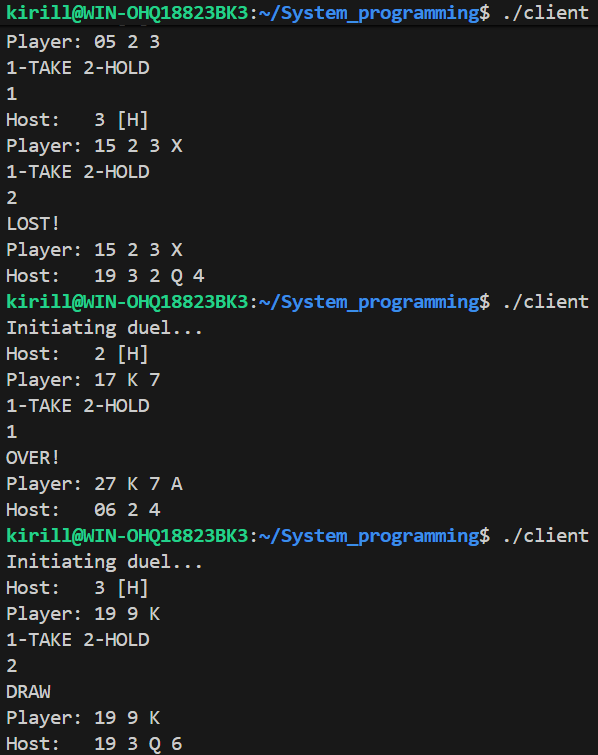

In [ ]:
format ELF64

section '.data' writeable align 16
    ; Строки
    prompt_x    db "Enter x value: ", 0
    prompt_eps  db "Enter precision (e.g. 0.0000001): ", 0
    scan_fmt    db "%lf", 0
    out_fmt     db "x: %.5f | My cos (SSE): %.10f | Lib cos: %.10f | Iterations: %d", 10, 0

    ; Константы (double)
    align 16
    one         dq 1.0
    four        dq 4.0
    pi_sq       dq 9.869604401089358      ; pi^2
    pi          dq 3.14159265358979323846 ; pi
    pi_half     dq 1.57079632679489661923 ; pi/2
    two_pi      dq 6.28318530717958647692 ; 2pi

    ; Маски (16-байтные для movapd)
    align 16
    abs_mask        dq 0x7FFFFFFFFFFFFFFF, 0x7FFFFFFFFFFFFFFF
    sign_bit_mask   dq 0x8000000000000000, 0x8000000000000000

section '.bss' writeable align 16
    x           dq ?
    eps         dq ?
    my_res      dq ?
    lib_res     dq ?
    x_reduced   dq ?
    sign_flag   dq ?
    iteration_count dq ?

section '.text' executable
    extrn printf
    extrn scanf
    extrn cos
    extrn exit

    public main

main:
    push    rbp
    mov     rbp, rsp
    sub     rsp, 32

    ; --- Ввод данных ---
    lea     rdi, [prompt_x]
    xor     rax, rax
    call    printf

    lea     rdi, [scan_fmt]
    lea     rsi, [x]
    xor     rax, rax
    call    scanf

    lea     rdi, [prompt_eps]
    xor     rax, rax
    call    printf

    lea     rdi, [scan_fmt]
    lea     rsi, [eps]
    xor     rax, rax
    call    scanf

    ; =============================================================
    ; Приведение аргумента (Range Reduction)
    ; =============================================================

    ; Загрузка x и взятие модуля
    movsd   xmm0, [x]
    movq    xmm1, [abs_mask]    ; movq для 8-байтной загрузки
    andpd   xmm0, xmm1          ; |x|

    ; x = |x| % 2pi
    movapd  xmm1, xmm0
    divsd   xmm1, [two_pi]      ; x / 2pi
    cvttsd2si rax, xmm1         ; floor(x / 2pi)
    cvtsi2sd xmm2, rax
    mulsd   xmm2, [two_pi]      ; floor(x/2pi)*2pi
    subsd   xmm0, xmm2          ; остаток

    ; Корректировка, если результат стал < 0 из-за погрешности
    xorpd   xmm1, xmm1
    comisd  xmm0, xmm1
    jae     .positive_rem
    addsd   xmm0, [two_pi]
.positive_rem:

    ; --- Обработка квадрантов ---
    mov     qword [sign_flag], 0

    ; Проверка x > pi
    comisd  xmm0, [pi]
    jbe     .check_half

    ; x = 2pi - x
    movsd   xmm1, [two_pi]
    subsd   xmm1, xmm0
    movapd  xmm0, xmm1

.check_half:
    ; Проверка x > pi/2
    comisd  xmm0, [pi_half]
    jbe     .store_x

    ; x = pi - x, sign = 1
    movsd   xmm1, [pi]
    subsd   xmm1, xmm0
    movapd  xmm0, xmm1
    mov     qword [sign_flag], 1

.store_x:
    movsd   [x_reduced], xmm0

    ; =============================================================
    ; Вычисление ряда через бесконечное произведение
    ; cos(x) = ∏[n=1 to inf] (1 - (4x²)/((2n-1)²pi²))
    ; =============================================================

    ; Подготовка константы: Const = 4 * x^2 / pi^2
    movsd   xmm0, [x_reduced]
    mulsd   xmm0, xmm0          ; x²
    mulsd   xmm0, [four]        ; 4x²
    divsd   xmm0, [pi_sq]       ; Const = 4x²/pi²
    movsd   xmm7, xmm0          ; Сохраняем Const в xmm7

    movsd   xmm1, [one]         ; Результат (Product)
    mov     rcx, 1              ; Счетчик n
    movsd   xmm6, [eps]         ; Точность

.loop:
    ; (2n - 1)^2
    mov     rax, rcx
    shl     rax, 1              ; 2n
    dec     rax                 ; 2n-1
    cvtsi2sd xmm2, rax
    mulsd   xmm2, xmm2          ; (2n-1)²

    ; term = Const / (2n-1)²
    movapd  xmm3, xmm7
    divsd   xmm3, xmm2          ; term

    ; factor = 1 - term
    movsd   xmm4, [one]
    subsd   xmm4, xmm3          ; factor

    ; Сохраняем предыдущий результат
    movapd  xmm5, xmm1

    ; Обновляем результат: product *= factor
    mulsd   xmm1, xmm4

    ; --- Проверка точности ---
    ; Вычисляем abs(old - new)
    subsd   xmm5, xmm1          ; diff = old - new
    movq    xmm2, [abs_mask]    ; Загружаем маску для abs
    andpd   xmm5, xmm2          ; abs(diff)

    ; Проверяем abs(diff) < eps
    comisd  xmm5, xmm6
    jb      .done_loop          ; Если diff < eps, выходим

    inc     rcx
    cmp     rcx, 10000000
    jl      .loop

    ; Если дошли сюда, значит превысили максимальное число итераций
    mov     rcx, 10000000

.done_loop:
    ; Сохраняем количество итераций
    mov     [iteration_count], rcx

    ; Применение знака (для x в [pi/2, pi])
    cmp     qword [sign_flag], 1
    jne     .store_result

    movq    xmm2, [sign_bit_mask]
    xorpd   xmm1, xmm2          ; Меняем знак

.store_result:
    movsd   [my_res], xmm1

    ; Сверка с библиотечной функцией
    movsd   xmm0, [x]
    sub     rsp, 8              ; Выравнивание стека для вызова
    call    cos
    add     rsp, 8
    movsd   [lib_res], xmm0

    ; Вывод результатов
    lea     rdi, [out_fmt]
    movsd   xmm0, [x]
    movsd   xmm1, [my_res]
    movsd   xmm2, [lib_res]
    mov     rsi, [iteration_count]
    mov     rax, 3              ; 3 числа с плавающей точкой
    call    printf

    xor     rdi, rdi
    call    exit


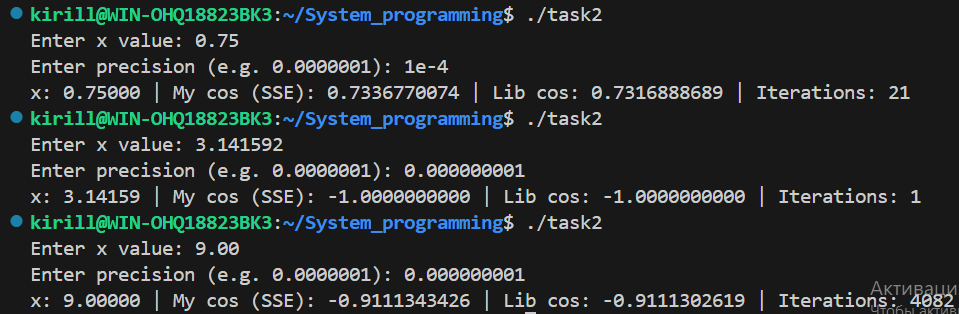